In [7]:
import satkit

# satkit.utils.update_datafiles()

In [8]:
from dotenv import load_dotenv
import os
import logging

logging.basicConfig(level=logging.INFO, filename='training.log', filemode='a', format='%(asctime)s %(levelname)s:%(message)s')
logging.info("Starting training script")

load_dotenv()

True

In [9]:
import torch
import torch.nn as nn
import numpy as np

if torch.cuda.is_available():
    torch.set_default_device('cuda')
    device_str = 'cuda'
else:
    device_str = 'cpu'

device = torch.device(device_str)

In [10]:
from torch.cuda.amp import autocast, GradScaler
from torch import optim
from dsgp4 import mldsgp4
from lazy_dataset.dataset import LazyDataset, TrainingStep, State
from dsgp4.tle import TLE
from util.transform import gcrf_to_teme
import satkit as sk
import time
from collections import defaultdict

def extract_batch_data(batch: list[TrainingStep]) -> tuple[list[TLE], list[State], torch.Tensor]:
    """
    Extracts TLEs and states from a batch of data.
    """
    tles = [step.tle for step in batch]
    all_state_lists = [step.states for step in batch]
    all_tsince_lists = [step.tsinces for step in batch]
    states = [state for state_list in all_state_lists for state in state_list]

    flattened_tles = [] # All TLEs repeated for each time step
    batched_steps = []
    for tle, tsince_list in zip(tles, all_tsince_lists):
        flattened_tles.extend([tle] * len(tsince_list))
        if len(tsince_list) > 0:
            batched_steps.extend(tsince_list) # Represent steps as actual time since epoch values

    batched_steps = torch.tensor(batched_steps, device=device)

    return flattened_tles, states, batched_steps

def normalize_ground_truth(states, normalization_R=6958.137, normalization_V=7.947155867983262):
    """
    Normalize ground truth states to match model's output space.
    
    Args:
        states: Tensor [N, 6] with positions (km) and velocities (km/s)
        
    Returns:
        normalized_states: Tensor [N, 6] in normalized units
    """
    normalized = torch.zeros_like(states)
    normalized[:, :3] = states[:, :3] / normalization_R  # Normalize positions
    normalized[:, 3:] = states[:, 3:] / normalization_V   # Normalize velocities
    
    return normalized

def descent(
        model,
        train:bool,
        dataset: LazyDataset,
        optimizer: optim.Optimizer,
        criterion: nn.Module = nn.SmoothL1Loss(),
        scaler: GradScaler = GradScaler(),
        chunk_size=512,
        ):
    
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_steps = 0
    start_time = time.time()
    for i, batch in enumerate(dataset):
        logging.info(f"Processing batch {i+1}/{len(dataset)} with {len(batch)} steps")
        tles, states, steps = extract_batch_data(batch)

        total_steps += len(steps)


        if train:
            optimizer.zero_grad()

        # Convert ground truth states to a normalized tensor in TEME frame
        logging.info(f"Converting {len(states)} ground truth states to TEME frame")
        rotation_start = time.time()
        # Group states by epoch to minimize redundant transformations
        logging.info(f"[1/2] Mapping epochs to indices")
        epoch_table = defaultdict(list)
        for index, state in enumerate(states):
            epoch_table[state.dt_time].append(index)
        logging.info(f"Found {len(epoch_table)} unique epochs for {len(states)} states in {time.time() - rotation_start:.2f} seconds")

        # Preallocate state tensor list
        state_tensors_teme = torch.zeros((len(states), 6), dtype=torch.float32, device=device)

        logging.info(f"[2/2] Converting states epoch by epoch")

        rotation_fn_time = time.time()
        for epoch, indices in epoch_table.items():
            states_for_epoch = [states[index] for index in indices]
            state_vectors = np.stack([np.concatenate([state.get_position_vector(), state.get_velocity_vector()]) for state in states_for_epoch])
            state_tensor_teme = gcrf_to_teme(
                torch.tensor(
                    state_vectors,
                    dtype=torch.float32,
                    device=device
                ), sk.time.from_datetime(epoch)
            )
            # Fancy indexing to place converted states in the correct positions
            state_tensors_teme[indices] = state_tensor_teme.squeeze(0)
        
        logging.info(f"[Done] Converted all states to TEME frame in {time.time() - rotation_fn_time:.2f} seconds")
        logging.info(f"Finished converting ground truth states to TEME frame in {time.time() - rotation_start:.2f} total seconds")
        normalization_start = time.time()
        target_states_normalized = normalize_ground_truth(state_tensors_teme)
        logging.info(f"Finished normalizing ground truth states in {time.time() - normalization_start:.2f} seconds")


        # Process in smaller chunks to save GPU memory
        accumulated_loss = 0.0
        propagation_start = time.time()
        logging.info(f"Propagating {len(steps)} steps in chunks of size {chunk_size}")

        # Wrap the forward pass with appropriate gradient context
        gradient_context = torch.enable_grad() if train else torch.no_grad()
        
        with gradient_context:
            for j in range(0, len(steps), chunk_size):
                with autocast():
                    chunk_states = model(tles[j:j+chunk_size], steps[j:j+chunk_size]).to(device)
                    # Compute the loss for the chunk
                    loss = criterion(chunk_states, target_states_normalized[j:j+chunk_size].to(device))
                    # Backpropagate the loss for this chunk
                    if train:
                        scaler.scale(loss).backward()
                accumulated_loss += loss.item()

        # Only step optimizer and scaler during training
        if train:
            scaler.step(optimizer)
            scaler.update()

        total_loss += accumulated_loss
        logging.info(f"Accumulated loss for batch {i+1}: {accumulated_loss} | Average loss so far: {total_loss / total_steps:.4f}")
        logging.info(f"Finished propagating and backpropagating (if training) in {time.time() - propagation_start:.2f} seconds")
        logging.info(f"Finished batch {i+1}/{len(dataset)} in {(time.time() - start_time) / 60:.2f} minutes")


    logging.info(f"Finished epoch in {(time.time() - start_time) / 60:.2f} minutes")

    avg_loss = total_loss / total_steps
    return avg_loss

/tmp/ipykernel_4022966/2800062138.py:53: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler: GradScaler = GradScaler(),


In [11]:
def denormalize_predictions(normalized_states, normalization_R=6958.137, normalization_V=7.947155867983262):
    """Convert normalized predictions back to physical units."""
    denormalized = torch.zeros_like(normalized_states)
    denormalized[:, :3] = normalized_states[:, :3] * normalization_R  # km
    denormalized[:, 3:] = normalized_states[:, 3:] * normalization_V  # km/s
    return denormalized

def calculate_metrics(predictions, targets):
    """
    Calculate various accuracy and precision metrics for satellite state predictions.
    
    Args:
        predictions: Tensor [N, 6] - predicted states (position + velocity)
        targets: Tensor [N, 6] - ground truth states (position + velocity)
    
    Returns:
        dict: Dictionary containing various metrics
    """
    with torch.no_grad():
        # Position and velocity errors
        pos_pred = predictions[:, :3]  # km
        pos_true = targets[:, :3]      # km
        vel_pred = predictions[:, 3:]  # km/s
        vel_true = targets[:, 3:]      # km/s
        
        # Position metrics
        pos_error = pos_pred - pos_true
        pos_error_magnitude = torch.norm(pos_error, dim=1)  # Euclidean distance error
        pos_rmse = torch.sqrt(torch.mean(pos_error_magnitude ** 2))
        pos_mae = torch.mean(pos_error_magnitude)
        pos_max_error = torch.max(pos_error_magnitude)
        pos_std = torch.std(pos_error_magnitude)
        
        # Velocity metrics
        vel_error = vel_pred - vel_true
        vel_error_magnitude = torch.norm(vel_error, dim=1)
        vel_rmse = torch.sqrt(torch.mean(vel_error_magnitude ** 2))
        vel_mae = torch.mean(vel_error_magnitude)
        vel_max_error = torch.max(vel_error_magnitude)
        vel_std = torch.std(vel_error_magnitude)
        
        # Overall state vector error
        state_error = predictions - targets
        state_error_magnitude = torch.norm(state_error, dim=1)
        state_rmse = torch.sqrt(torch.mean(state_error_magnitude ** 2))
        state_mae = torch.mean(state_error_magnitude)
        
        # Accuracy thresholds (you can adjust these based on requirements)
        pos_accuracy_1km = (pos_error_magnitude < 1.0).float().mean() * 100  # % within 1 km
        pos_accuracy_5km = (pos_error_magnitude < 5.0).float().mean() * 100  # % within 5 km
        pos_accuracy_10km = (pos_error_magnitude < 10.0).float().mean() * 100  # % within 10 km
        
        vel_accuracy_01ms = (vel_error_magnitude < 0.01).float().mean() * 100  # % within 0.01 km/s
        vel_accuracy_05ms = (vel_error_magnitude < 0.05).float().mean() * 100  # % within 0.05 km/s
        vel_accuracy_10ms = (vel_error_magnitude < 0.10).float().mean() * 100  # % within 0.10 km/s
        
        return {
            'position_rmse_km': pos_rmse.item(),
            'position_mae_km': pos_mae.item(),
            'position_max_error_km': pos_max_error.item(),
            'position_std_km': pos_std.item(),
            'position_accuracy_1km_percent': pos_accuracy_1km.item(),
            'position_accuracy_5km_percent': pos_accuracy_5km.item(),
            'position_accuracy_10km_percent': pos_accuracy_10km.item(),
            
            'velocity_rmse_kmps': vel_rmse.item(),
            'velocity_mae_kmps': vel_mae.item(),
            'velocity_max_error_kmps': vel_max_error.item(),
            'velocity_std_kmps': vel_std.item(),
            'velocity_accuracy_001kmps_percent': vel_accuracy_01ms.item(),
            'velocity_accuracy_005kmps_percent': vel_accuracy_05ms.item(),
            'velocity_accuracy_010kmps_percent': vel_accuracy_10ms.item(),
            
            'overall_state_rmse': state_rmse.item(),
            'overall_state_mae': state_mae.item(),
            
            'num_samples': len(predictions)
        }

def test_model(model, dataset, chunk_size=2**19):
    """Test the model and calculate accuracy/precision metrics."""
    model.eval()
    
    all_predictions = []
    all_targets = []
    
    total_samples = 0
    start_time = time.time()
    
    with torch.no_grad():
        for i, batch in enumerate(dataset):
            logging.info(f"Processing batch {i+1}/{len(dataset)} with {len(batch)} steps")
            tles, states, steps = extract_batch_data(batch)
            
            # Convert ground truth states to TEME frame
            logging.info(f"Converting {len(states)} ground truth states to TEME frame")
            epoch_table = defaultdict(list)
            for index, state in enumerate(states):
                epoch_table[state.dt_time].append(index)
            
            state_tensors_teme = torch.zeros((len(states), 6), dtype=torch.float32, device=device)
            
            for epoch, indices in epoch_table.items():
                states_for_epoch = [states[index] for index in indices]
                state_vectors = np.stack([
                    np.concatenate([state.get_position_vector(), state.get_velocity_vector()]) 
                    for state in states_for_epoch
                ])
                state_tensor_teme = gcrf_to_teme(
                    torch.tensor(state_vectors, dtype=torch.float32, device=device), 
                    sk.time.from_datetime(epoch)
                )
                state_tensors_teme[indices] = state_tensor_teme.squeeze(0)
            
            # Normalize ground truth
            target_states_normalized = normalize_ground_truth(state_tensors_teme)
            
            # Get model predictions in chunks
            predictions_normalized = []
            for j in range(0, len(steps), chunk_size):
                with autocast():
                    chunk_predictions = model(tles[j:j+chunk_size], steps[j:j+chunk_size]).to(device)
                    predictions_normalized.append(chunk_predictions)
            
            predictions_normalized = torch.cat(predictions_normalized, dim=0)
            
            # Denormalize predictions and targets for metric calculation
            predictions_physical = denormalize_predictions(predictions_normalized)
            targets_physical = denormalize_predictions(target_states_normalized)
            
            all_predictions.append(predictions_physical)
            all_targets.append(targets_physical)
            total_samples += len(predictions_physical)
            
            logging.info(f"Processed batch {i+1}, total samples: {total_samples}")
    
    # Concatenate all predictions and targets
    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    # Calculate metrics
    logging.info("Calculating accuracy and precision metrics...")
    metrics = calculate_metrics(all_predictions, all_targets)
    
    # Log results
    logging.info("\n" + "="*60)
    logging.info("SATELLITE ORBIT PREDICTION TEST RESULTS")
    logging.info("="*60)
    logging.info(f"Total samples tested: {metrics['num_samples']}")
    logging.info(f"Test duration: {(time.time() - start_time) / 60:.2f} minutes")
    logging.info("")
    
    logging.info("POSITION ACCURACY:")
    logging.info(f"  RMSE: {metrics['position_rmse_km']:.3f} km")
    logging.info(f"  MAE:  {metrics['position_mae_km']:.3f} km")
    logging.info(f"  Max Error: {metrics['position_max_error_km']:.3f} km")
    logging.info(f"  Std Dev: {metrics['position_std_km']:.3f} km")
    logging.info(f"  Accuracy (≤1 km):  {metrics['position_accuracy_1km_percent']:.1f}%")
    logging.info(f"  Accuracy (≤5 km):  {metrics['position_accuracy_5km_percent']:.1f}%")
    logging.info(f"  Accuracy (≤10 km): {metrics['position_accuracy_10km_percent']:.1f}%")
    logging.info("")
    
    logging.info("VELOCITY ACCURACY:")
    logging.info(f"  RMSE: {metrics['velocity_rmse_kmps']:.6f} km/s")
    logging.info(f"  MAE:  {metrics['velocity_mae_kmps']:.6f} km/s")
    logging.info(f"  Max Error: {metrics['velocity_max_error_kmps']:.6f} km/s")
    logging.info(f"  Std Dev: {metrics['velocity_std_kmps']:.6f} km/s")
    logging.info(f"  Accuracy (≤0.01 km/s): {metrics['velocity_accuracy_001kmps_percent']:.1f}%")
    logging.info(f"  Accuracy (≤0.05 km/s): {metrics['velocity_accuracy_005kmps_percent']:.1f}%")
    logging.info(f"  Accuracy (≤0.10 km/s): {metrics['velocity_accuracy_010kmps_percent']:.1f}%")
    logging.info("")
    
    logging.info("OVERALL METRICS:")
    logging.info(f"  State Vector RMSE: {metrics['overall_state_rmse']:.3f}")
    logging.info(f"  State Vector MAE:  {metrics['overall_state_mae']:.3f}")
    logging.info("="*60)
    
    return metrics

In [ ]:
from lazy_dataset.dataset import LazyDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import json

TRAIN_PATH = os.getenv("TRAIN_PATH")
TEST_PATH = os.getenv("TEST_PATH")
VAL_PATH = os.getenv("VAL_PATH")

if TRAIN_PATH is None or TEST_PATH is None or VAL_PATH is None:
    raise ValueError("One or more dataset paths are not set in the environment variables.")

# Number of TLE integrated files per batch
batch_size = 12
# Use multiprocessing for data loading
mp = True
# Chunk sizes for processing within batches (the true batch size for GPU processing)
chunk_size = 2**19
# Number of states per TLE to use during training (Sampled randomly each epoch, maximizing diversity if there are extra states)
states_per_tle = 128  

train_satellites = LazyDataset(TRAIN_PATH, batch_size=batch_size, multiprocess=mp, num_states_per_tle=states_per_tle)
test_satellites = LazyDataset(TEST_PATH, batch_size=batch_size, multiprocess=mp, num_states_per_tle=states_per_tle)
val_satellites = LazyDataset(VAL_PATH, batch_size=batch_size, multiprocess=mp, num_states_per_tle=states_per_tle)

EPOCHS = 20

for lr in [0.01, 0.001, 0.0005, 0.0001, 0.00005, 0.00001, 0.000005, 0.000001]:
    for optimizer_name in ['AdamW', 'SGD', 'RMSprop']:
        model = mldsgp4().to(device)
        criterion = nn.SmoothL1Loss()
        if optimizer_name == 'AdamW':
            optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)
        elif optimizer_name == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.05)
        elif optimizer_name == 'RMSprop':
            optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=0.05)
        else:
            raise ValueError(f"Unsupported optimizer: {optimizer_name}")
        
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
        scaler = GradScaler()
        logging.info(f"Initialized model with {optimizer_name} optimizer and learning rate {lr}")

        test_metrics = None  # Initialize to avoid unbound error

        for epoch in range(EPOCHS):
            logging.info(f"Starting epoch {epoch+1}/{EPOCHS} with {optimizer_name} optimizer and learning rate {lr}")
            train_loss = descent(
                model=model,
                train=True,
                dataset=train_satellites,
                optimizer=optimizer,
                criterion=criterion,
                scaler=scaler,
                chunk_size=chunk_size
            )
            logging.info(f"Epoch {epoch+1}/{EPOCHS} training loss: {train_loss:.6f}")

            val_loss = descent(
                model=model,
                train=False,
                dataset=val_satellites,
                optimizer=optimizer,
                criterion=criterion,
                scaler=scaler,
                chunk_size=chunk_size
            )
            logging.info(f"Epoch {epoch+1}/{EPOCHS} validation loss: {val_loss:.6f}")

            scheduler.step(val_loss)

            test_metrics = test_model(model, test_satellites, chunk_size=chunk_size)

        # Save the trained model
        model_filename = f"mldsgp4_model_{optimizer_name}_lr{lr}.pth"
        torch.save(model.state_dict(), model_filename)
        logging.info(f"Saved trained model to {model_filename}")

        if test_metrics is not None:
            results_filename = f"final_test_metrics_{optimizer_name}_lr{lr}.json"
            with open(results_filename, 'w') as f:
                json.dump(test_metrics, f, indent=4)
            logging.info(f"Saved final test metrics to {results_filename}")

/tmp/ipykernel_4022966/282369196.py:41: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_4022966/2800062138.py:121: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


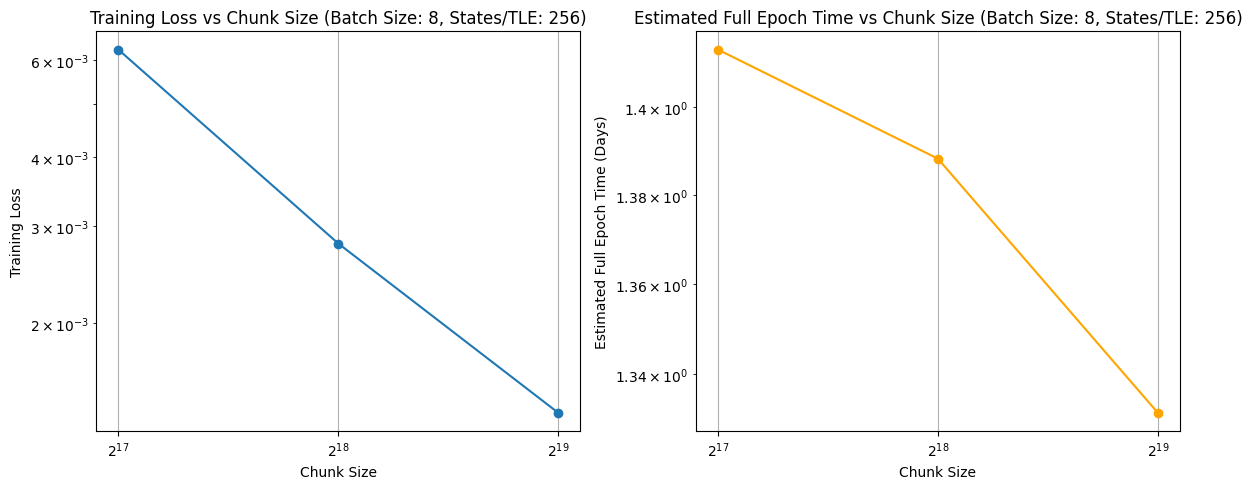

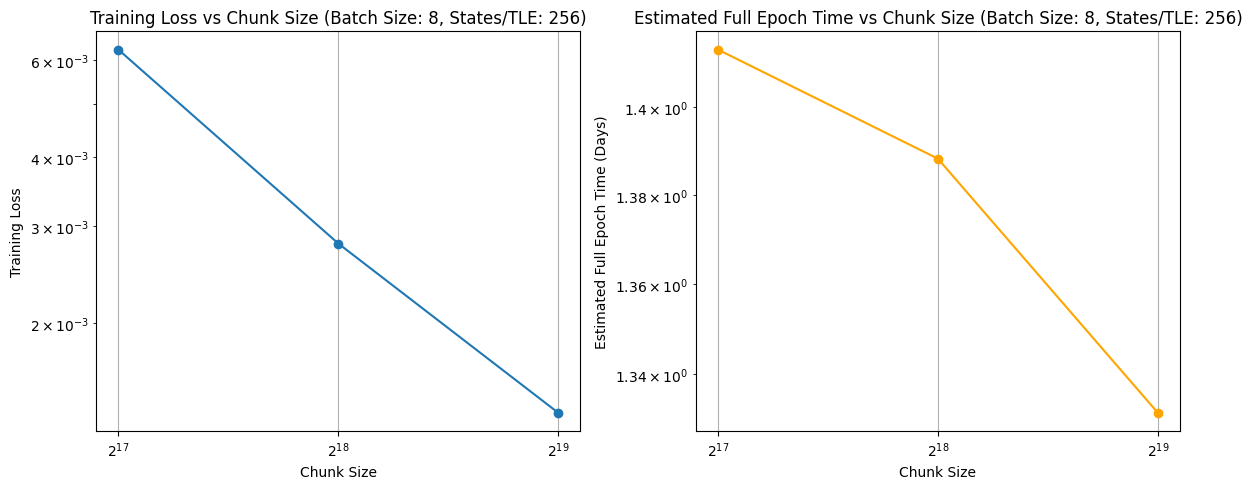

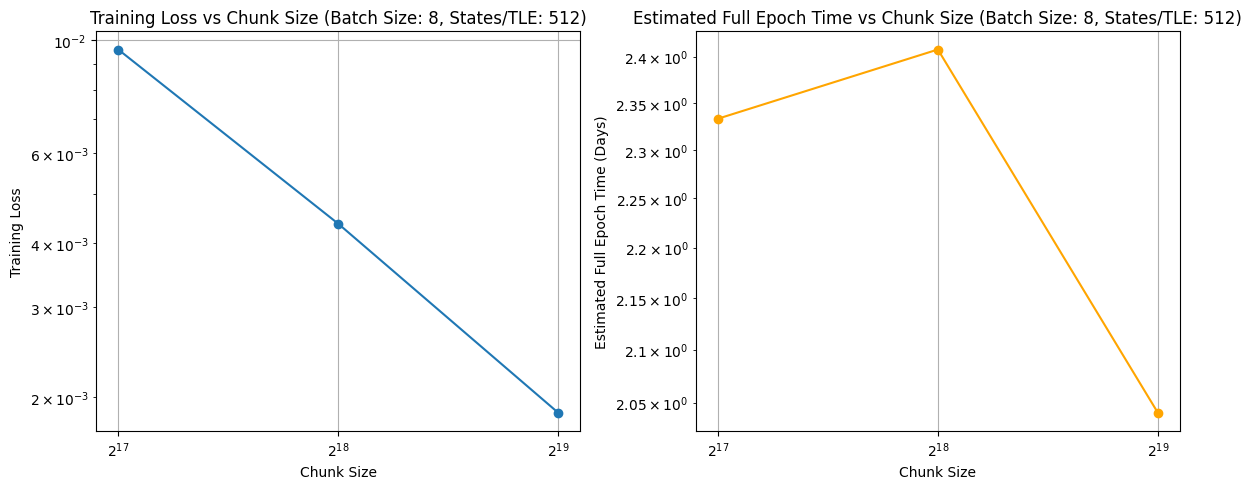

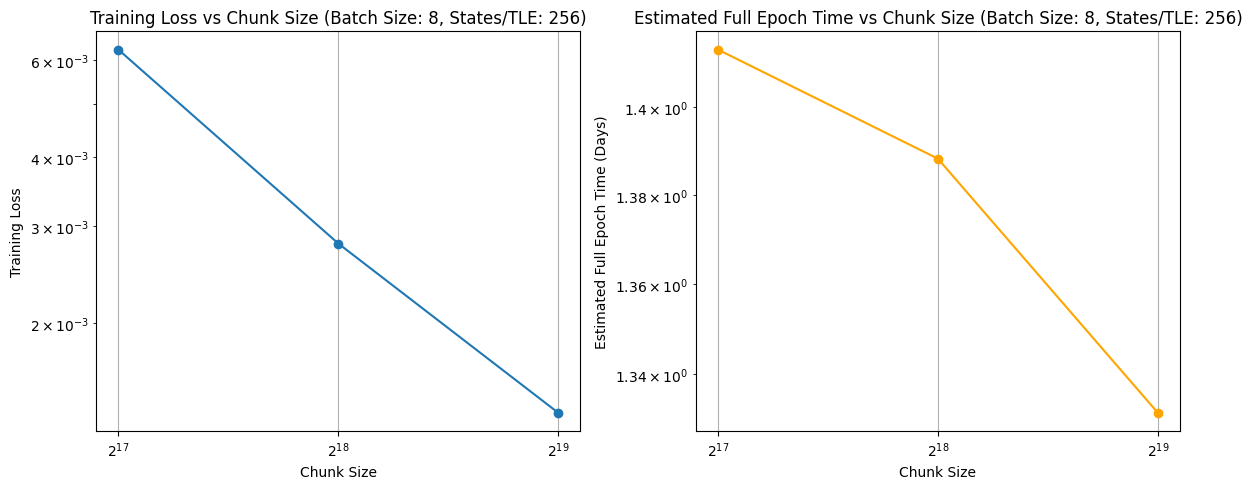

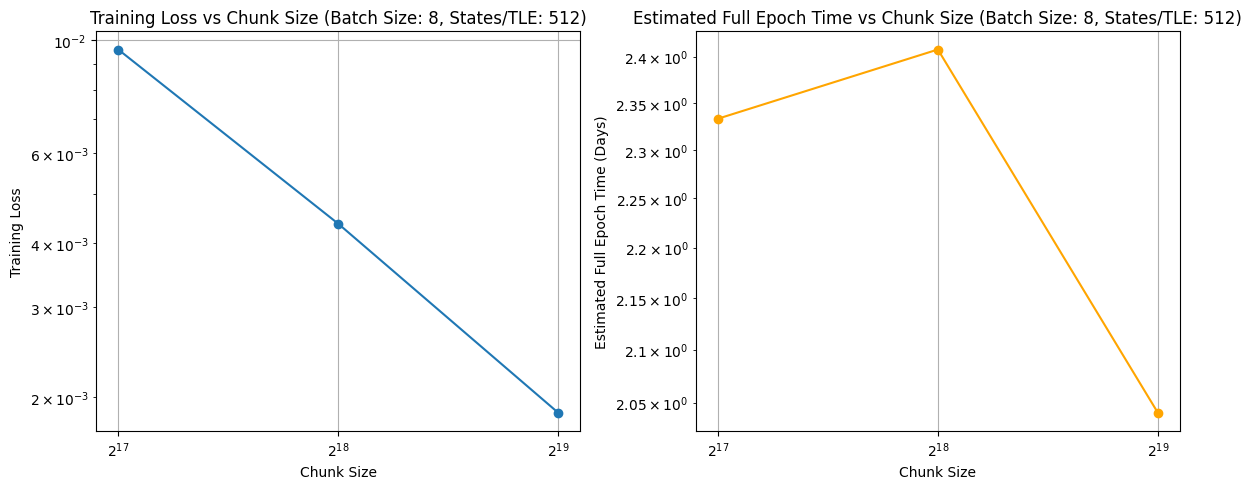

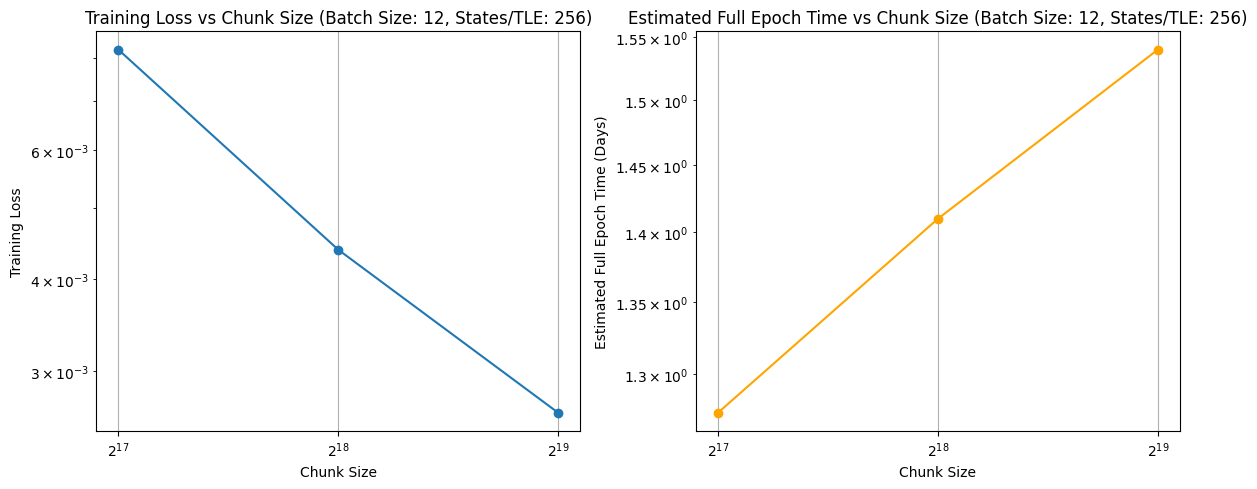

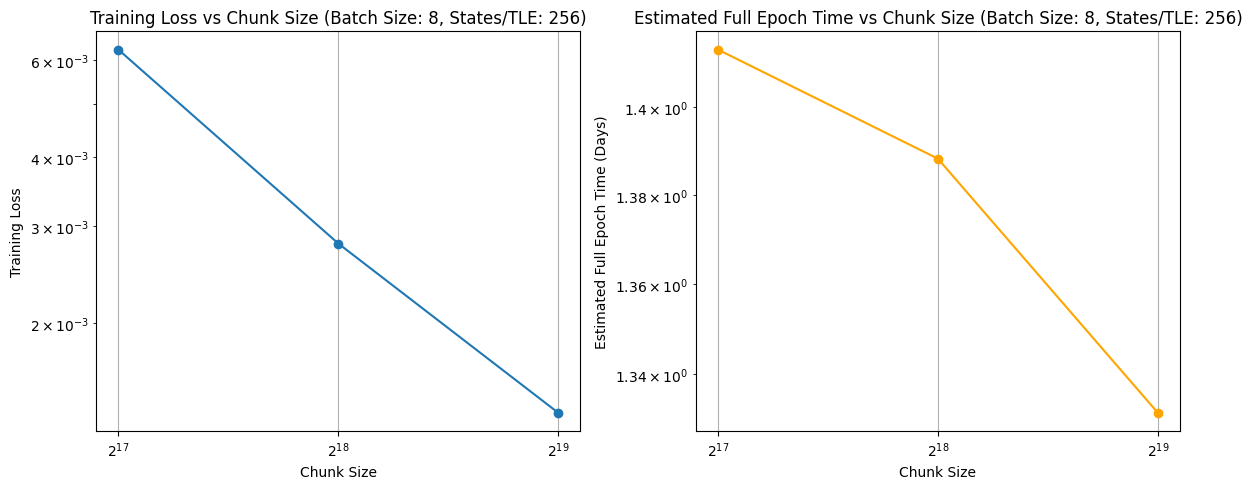

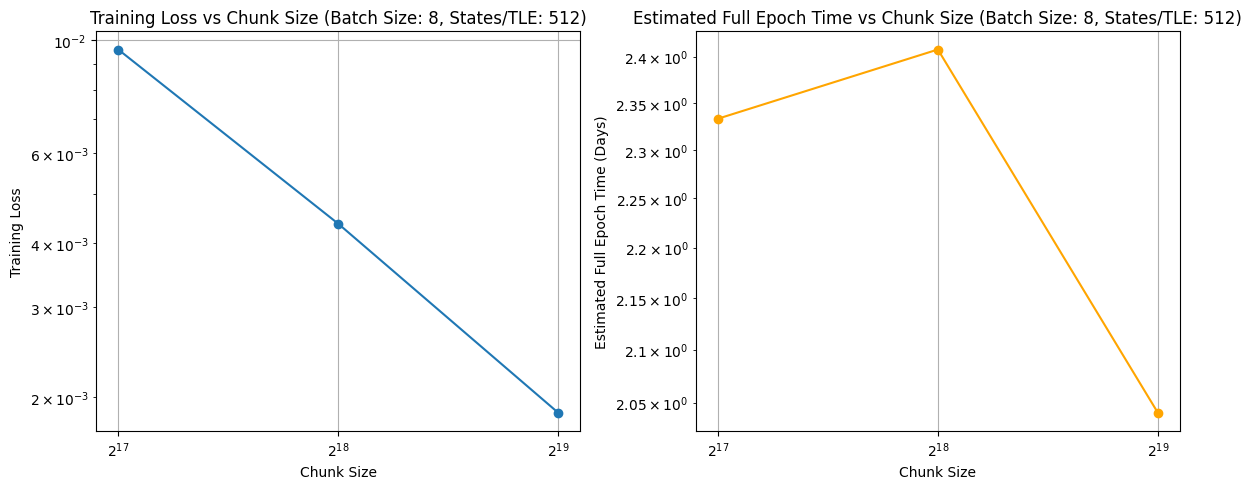

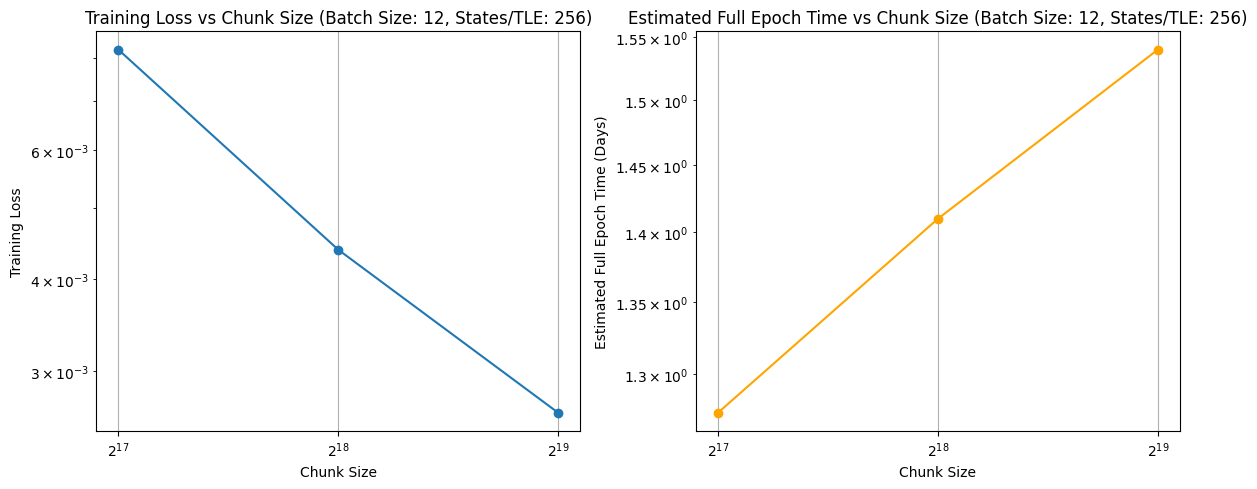

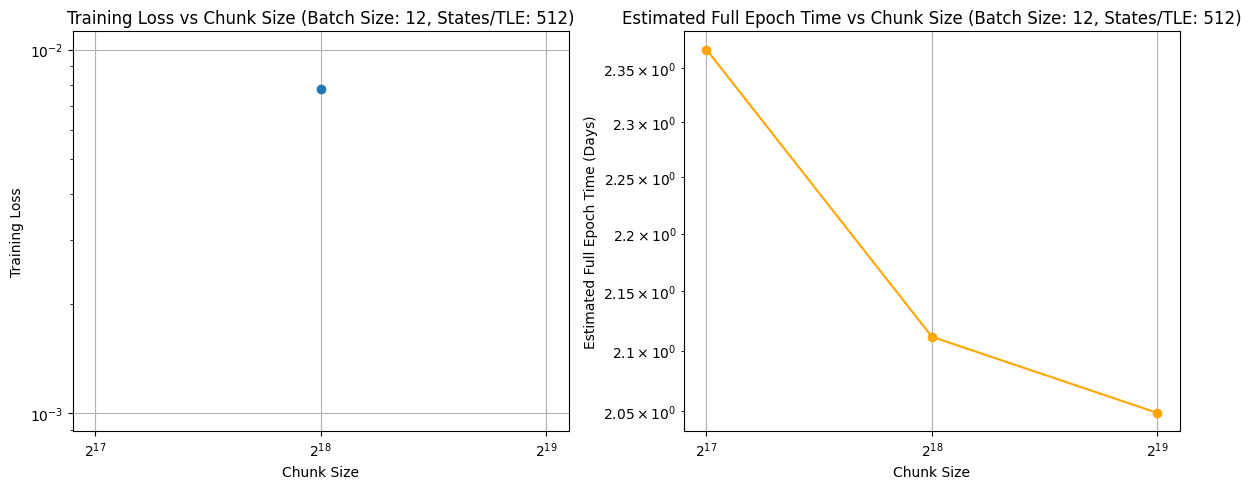

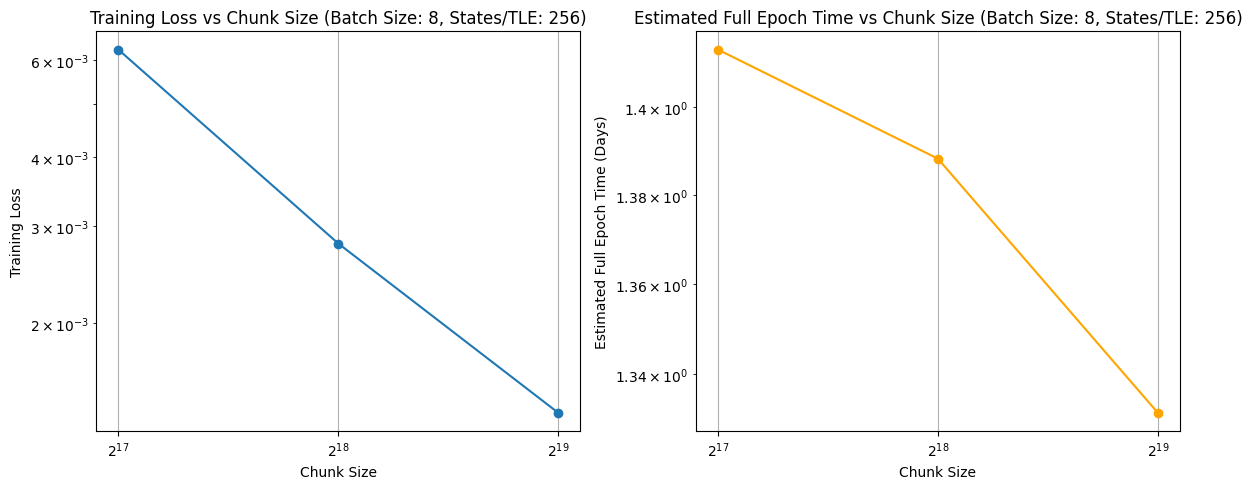

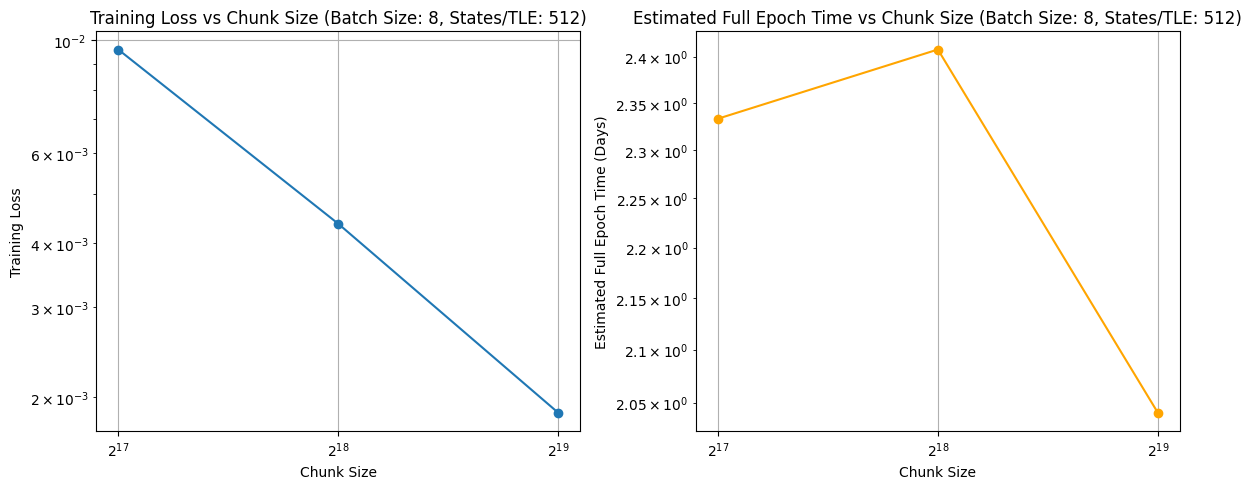

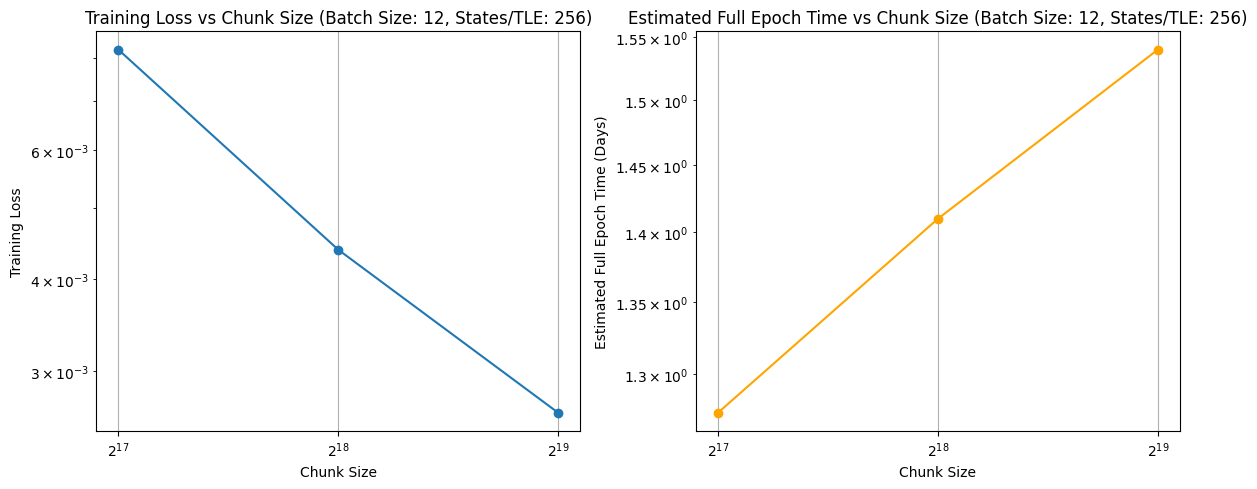

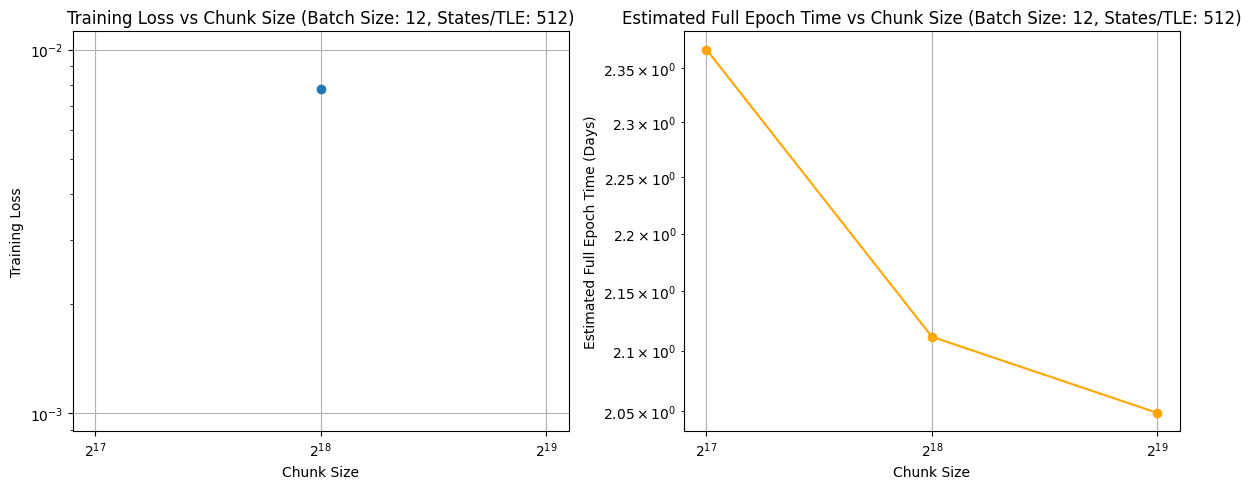

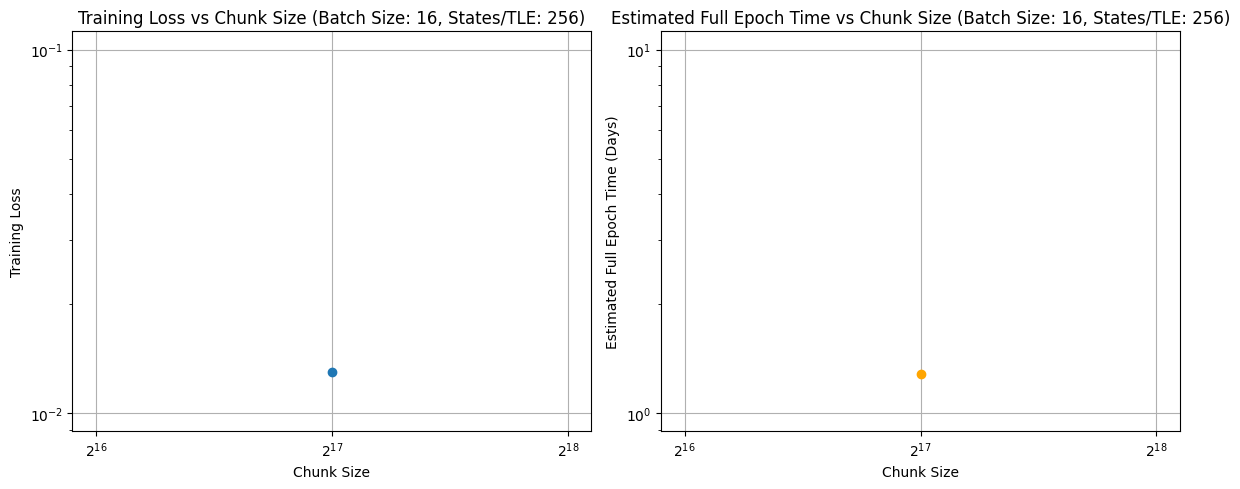

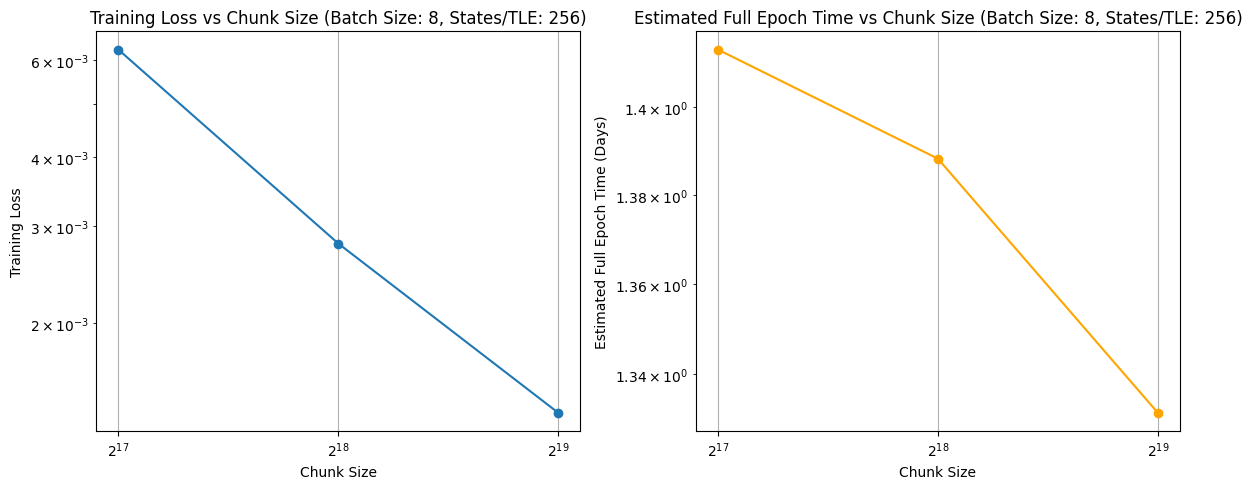

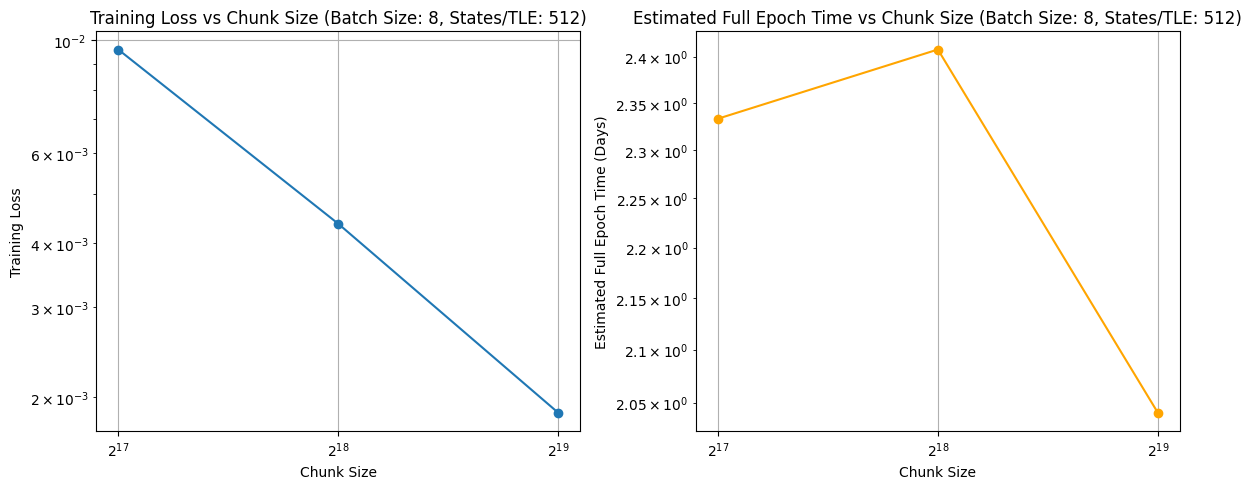

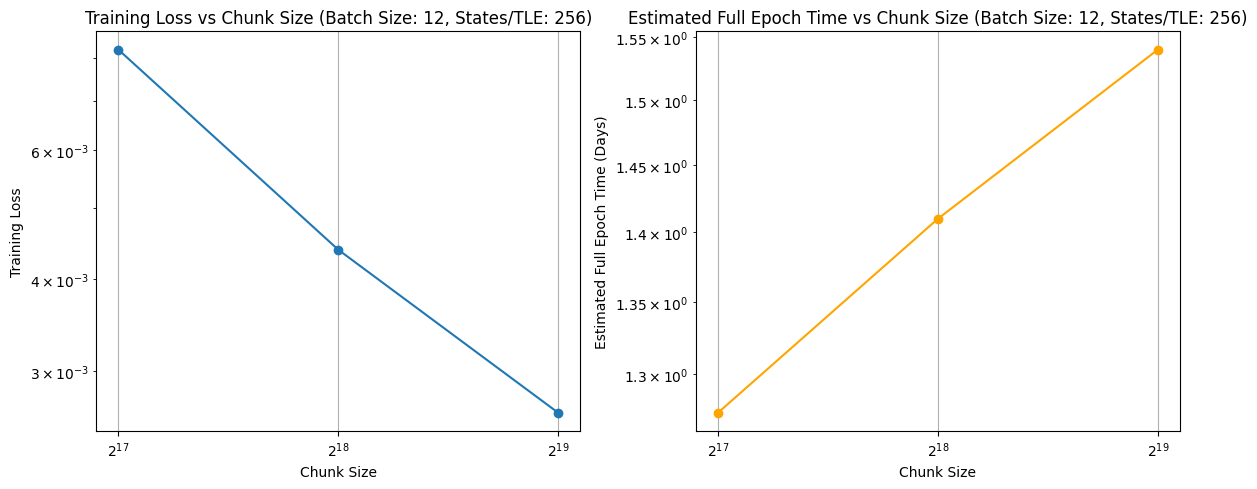

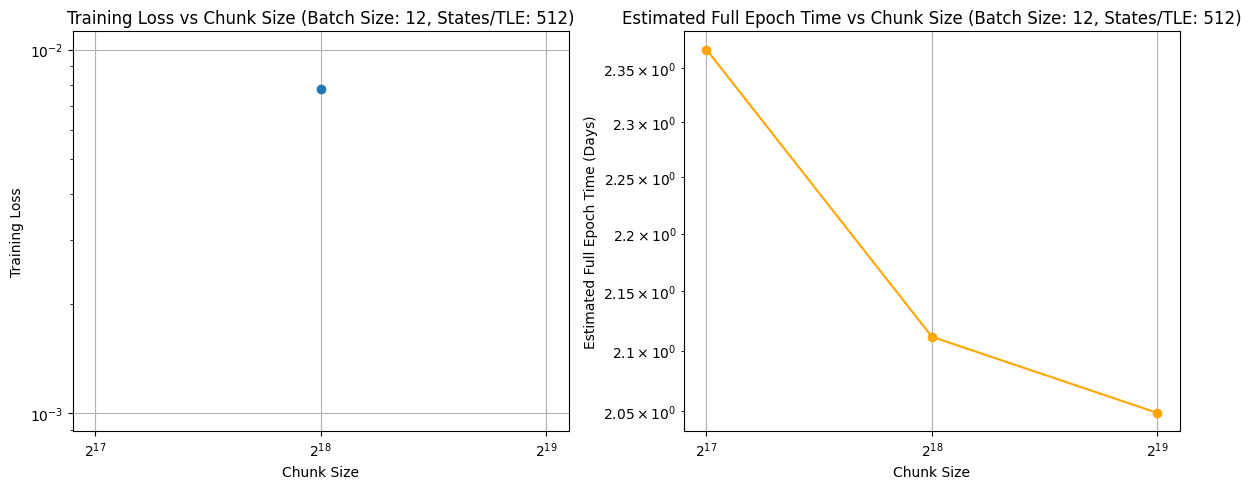

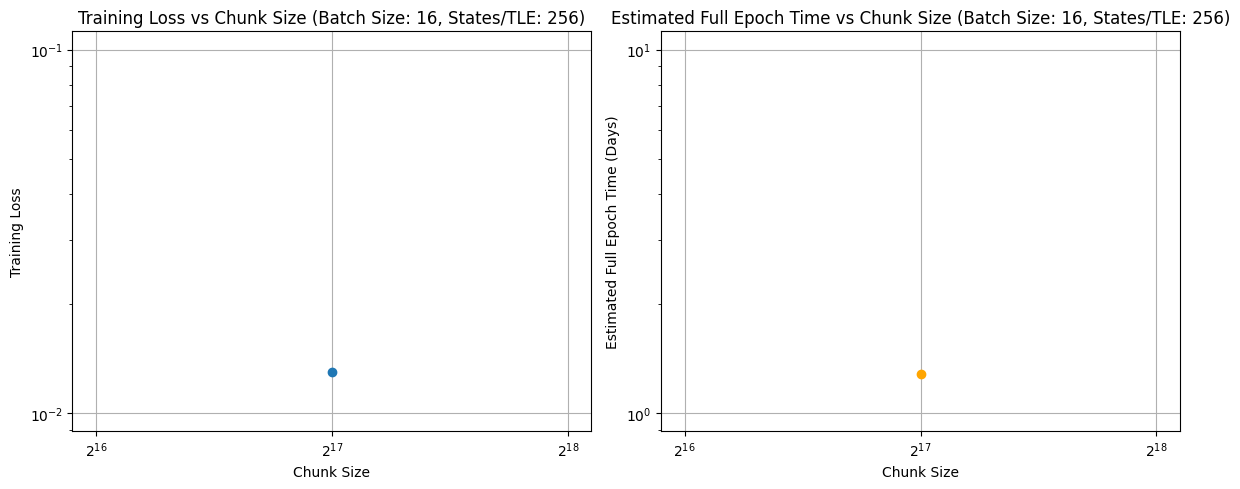

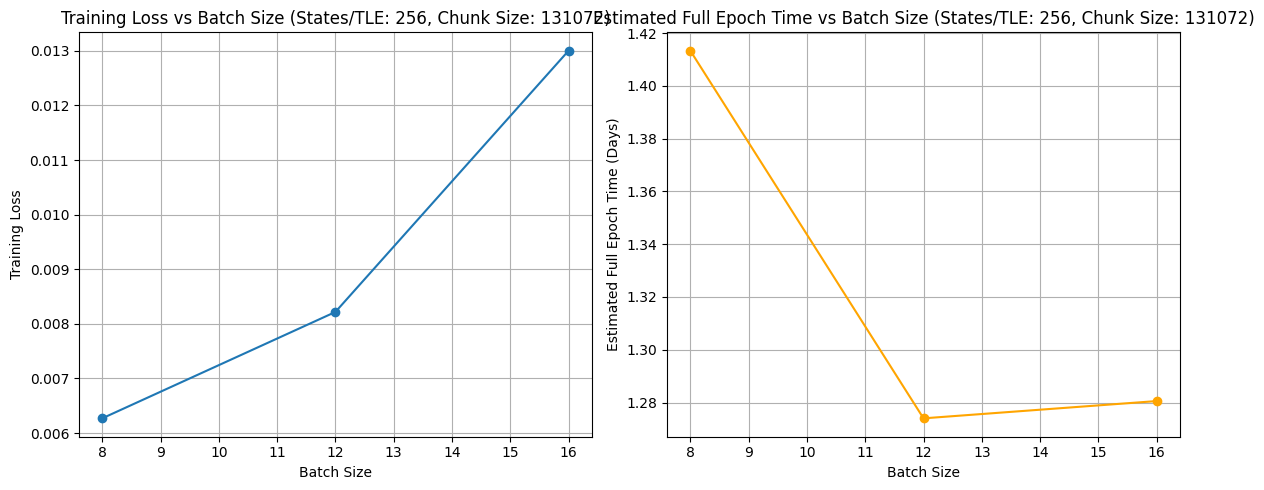

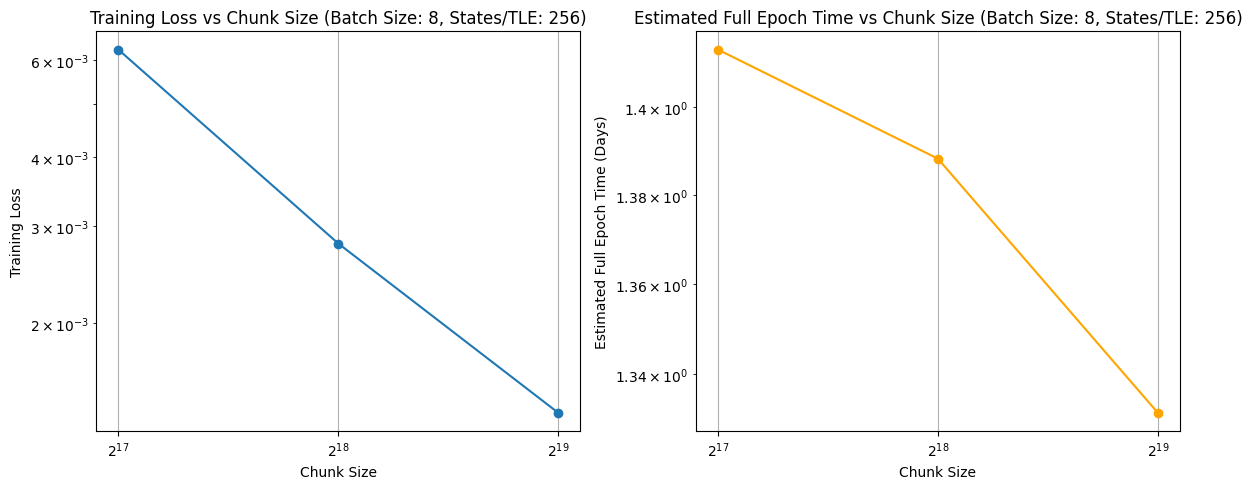

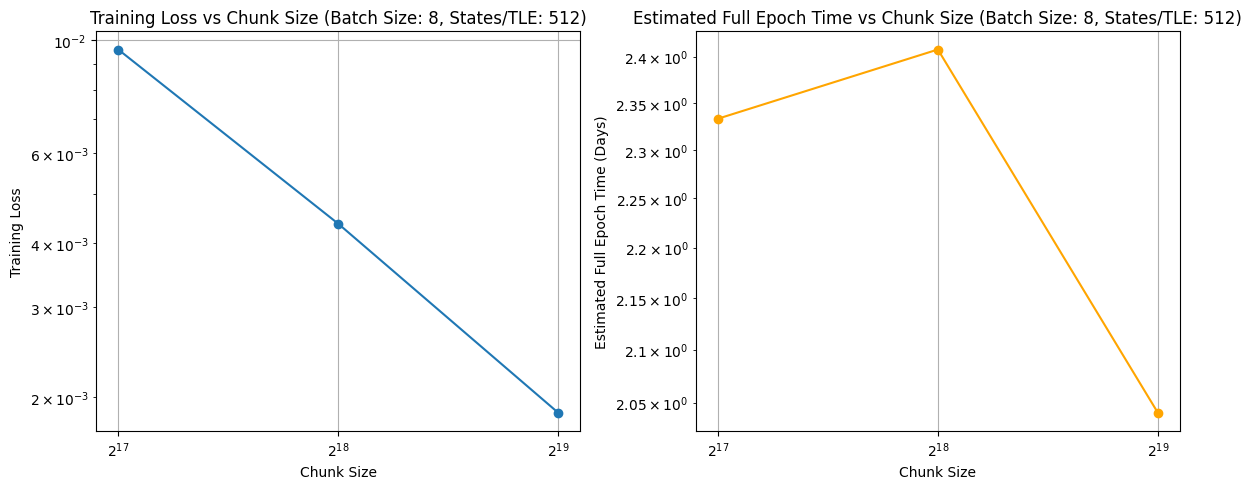

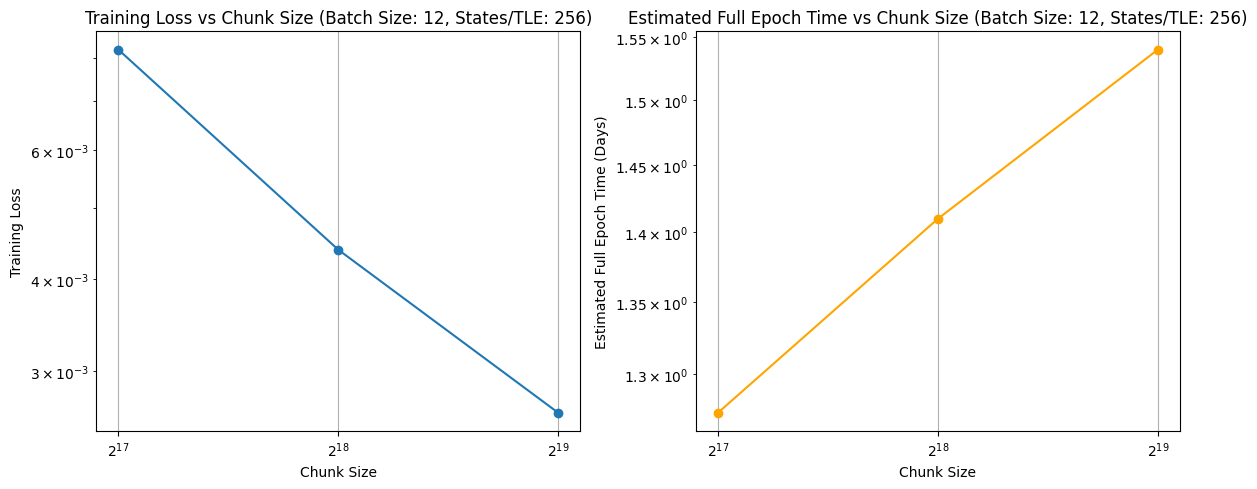

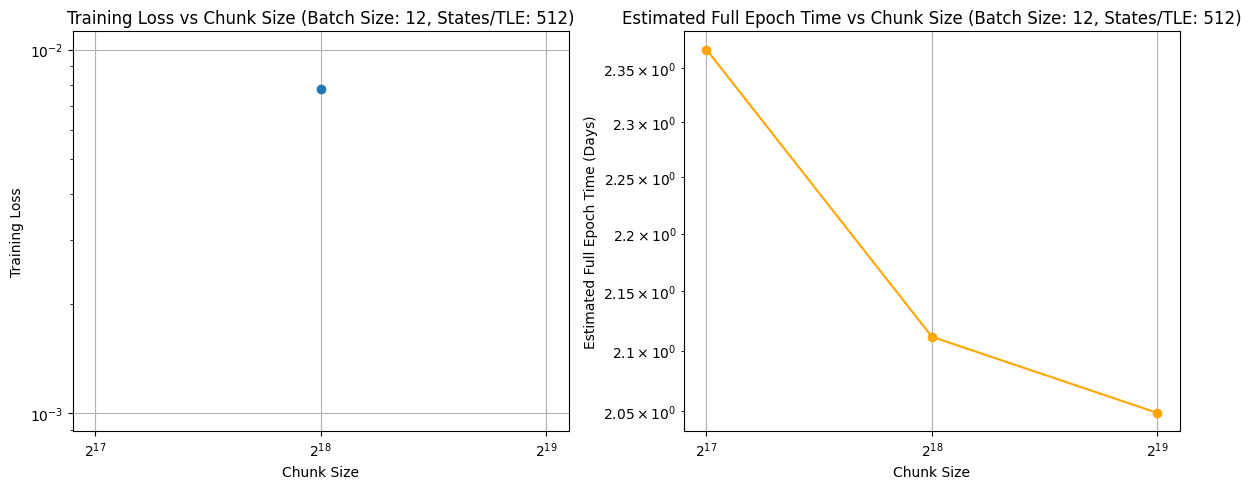

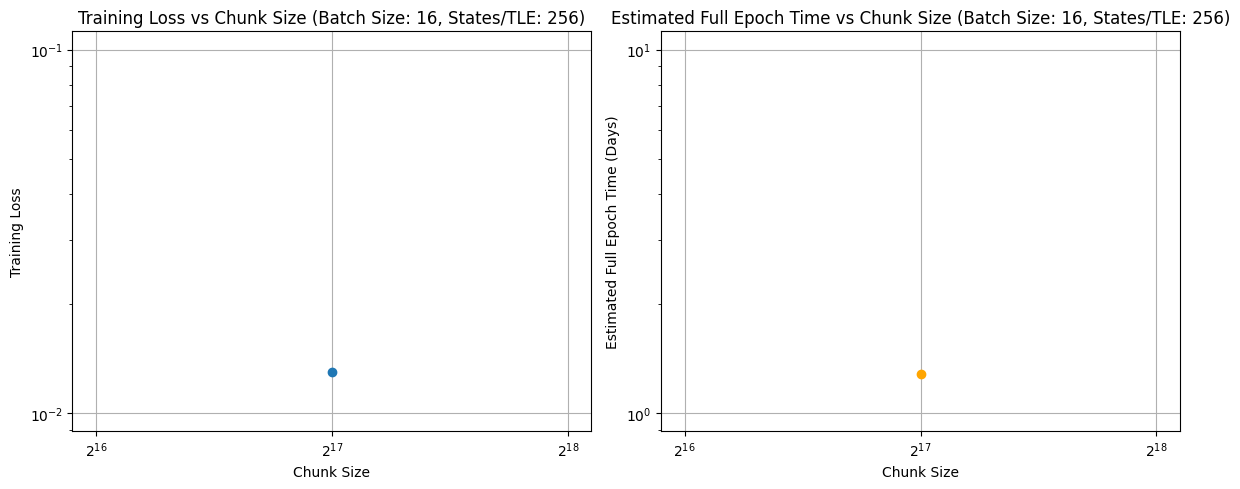

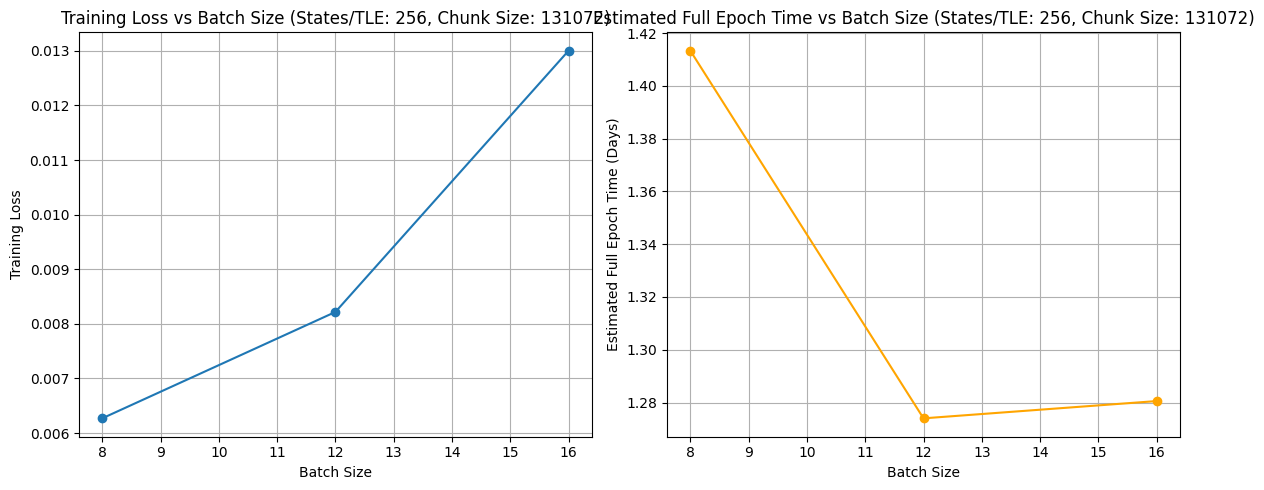

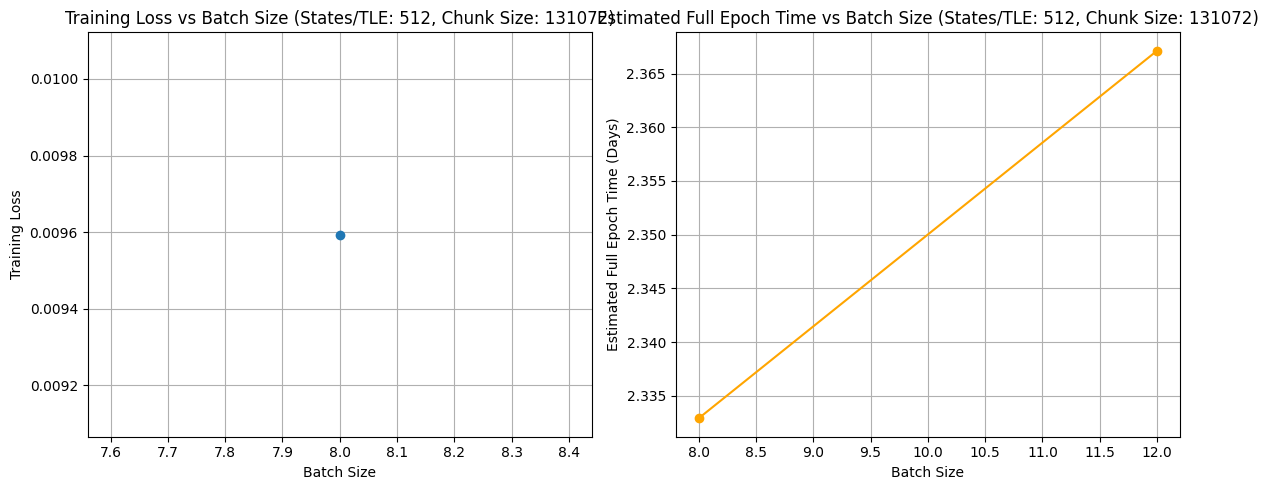

In [ ]:
# EPOCHS = 100

# LRS = [0.01, 0.001, 0.0001, 0.00001]
# OPTIMIZERS = [
# ]

# training_loss_over_time = []    
# testing_loss_over_time = []
# validation_loss_over_time = []

# for epoch in range(EPOCHS):
#     logging.info(f"Epoch {epoch+1}/{EPOCHS}")
    
#     # Training
#     model.train()
#     train_loss = train(model, train_satellites, optimizer, criterion, chunk_size=2**19)
#     logging.info(f"Training loss: {train_loss}")
#     training_loss_over_time.append(train_loss)

#     # Evaluation
#     # model.eval()
#     # test_loss = eval(model, test_satellites, optimizer)
#     # testing_loss_over_time.append(test_loss)

#     # # Validation
#     # val_loss = eval(model, val_satellites, optimizer)
#     # validation_loss_over_time.append(val_loss)

/tmp/ipykernel_3228989/1621245719.py:113: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
